In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gudhi
from pyproj import Transformer
from sklearn.metrics import pairwise_distances

In [2]:
from mytopotest.topotest import TopoTestTwosample, compute_ecc_contributions_alpha

In [3]:
#  GCJ-02 → WGS-84 
def gcj02_to_wgs84(lon, lat):
    import math
    a = 6378245.0
    ee = 0.00669342162296594323
    pi = math.pi

    def transformlat(lon, lat):
        ret = -100.0 + 2.0*lon + 3.0*lat + 0.2*lat*lat + 0.1*lon*lat + 0.2*math.sqrt(abs(lon))
        ret += (20.0*math.sin(6.0*lon*pi) + 20.0*math.sin(2.0*lon*pi)) * 2.0 / 3.0
        ret += (20.0*math.sin(lat*pi) + 40.0*math.sin(lat/3.0*pi)) * 2.0 / 3.0
        ret += (160.0*math.sin(lat/12.0*pi) + 320*math.sin(lat*pi/30.0)) * 2.0 / 3.0
        return ret

    def transformlon(lon, lat):
        ret = 300.0 + lon + 2.0*lat + 0.1*lon*lon + 0.1*lon*lat + 0.1*math.sqrt(abs(lon))
        ret += (20.0*math.sin(6.0*lon*pi) + 20.0*math.sin(2.0*lon*pi)) * 2.0 / 3.0
        ret += (20.0*math.sin(lon*pi) + 40.0*math.sin(lon/3.0*pi)) * 2.0 / 3.0
        ret += (150.0*math.sin(lon/12.0*pi) + 300.0*math.sin(lon/30.0*pi)) * 2.0 / 3.0
        return ret

    dlat = transformlat(lon-105.0, lat-35.0)
    dlon = transformlon(lon-105.0, lat-35.0)
    radlat = lat / 180.0 * pi
    magic = math.sin(radlat)
    magic = 1 - ee*magic*magic
    sqrtmagic = math.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrtmagic) * pi)
    dlon = (dlon * 180.0) / (a / sqrtmagic * math.cos(radlat) * pi)
    mglat = lat + dlat
    mglon = lon + dlon
    return lon * 2 - mglon, lat * 2 - mglat

In [4]:
from pyproj import Transformer
import numpy as np

def convert_gcj02_wgs84_utm50n(df):
    """
    GCJ-02 → WGS-84 → UTM-50N
    """
    lon_gcj = df["longitude"].values
    lat_gcj = df["latitude"].values

    # GCJ-02 → WGS-84
    wgs84_coords = np.array([gcj02_to_wgs84(lon, lat) for lon, lat in zip(lon_gcj, lat_gcj)])
    lon_wgs84, lat_wgs84 = wgs84_coords[:, 0], wgs84_coords[:, 1]

    df["lon_wgs84"] = lon_wgs84
    df["lat_wgs84"] = lat_wgs84

    # UTM Zone 50N
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:32650", always_xy=True)
    x_utm, y_utm = transformer.transform(lon_wgs84, lat_wgs84)

    df["utm_zone"] = 50 
    df["x_utm"] = x_utm
    df["y_utm"] = y_utm

    return df

In [5]:
# Read data
companies_df = pd.read_excel("company-ZJ-1.xlsx")
universities_df = pd.read_excel("university-ZJ-1.xlsx")

In [6]:
# convert
companies_df = convert_gcj02_wgs84_utm50n(companies_df)
universities_df = convert_gcj02_wgs84_utm50n(universities_df)

In [7]:
# Save results to file
companies_df.to_excel("company_converted-ZJ-1.xlsx", index=False)
universities_df.to_excel("university_converted-ZJ-1.xlsx", index=False)

In [8]:
# Load the UTM projected coordinates of universities and enterprises 
df_uni = pd.read_excel("university_converted-ZJ-1.xlsx")    
df_comp = pd.read_excel("company_converted-ZJ-1.xlsx")

In [9]:
# Extract x_utm and y_utm coordinates and remove missing values
uni_coords = df_uni[["x_utm", "y_utm"]].dropna().astype(float).values
comp_coords = df_comp[["x_utm", "y_utm"]].dropna().astype(float).values

In [10]:
print("uni_coords preview:\n", uni_coords[:5])
print("comp_coords preview:\n", comp_coords[:5])

uni_coords preview:
 [[ 736592.52754452 3565546.23118219]
 [ 731459.61916587 3565772.70133522]
 [ 722528.9311092  3555361.34014989]
 [ 732271.09735612 3565025.74647253]
 [ 704756.42016407 3538340.35829131]]
comp_coords preview:
 [[ 758260.79776027 3570328.81168106]
 [ 761908.42584234 3570998.79406608]
 [ 743801.17629823 3540468.11381207]
 [ 770968.94819225 3560819.8541597 ]
 [ 707746.66206169 3563216.31758967]]


In [11]:
print("uni_coords range:")
print("  x:", uni_coords[:, 0].min(), "to", uni_coords[:, 0].max())
print("  y:", uni_coords[:, 1].min(), "to", uni_coords[:, 1].max())

print("comp_coords range:")
print("  x:", comp_coords[:, 0].min(), "to", comp_coords[:, 0].max())
print("  y:", comp_coords[:, 1].min(), "to", comp_coords[:, 1].max())

uni_coords range:
  x: 704756.4201640664 to 767880.0058669534
  y: 3538340.358291313 to 3572916.043953882
comp_coords range:
  x: 689000.9401032084 to 775852.843566884
  y: 3505669.943757256 to 3576020.752459476


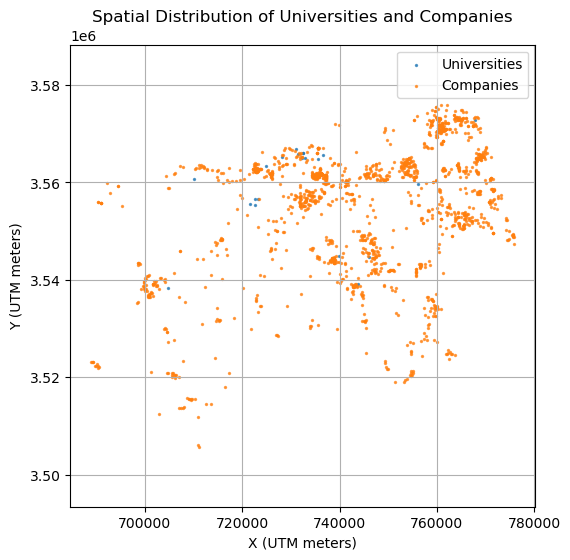

In [12]:
plt.figure(figsize=(6, 6))
plt.scatter(uni_coords[:, 0], uni_coords[:, 1], s=2, label="Universities", alpha=0.7)
plt.scatter(comp_coords[:, 0], comp_coords[:, 1], s=2, label="Companies", alpha=0.7)
plt.legend()
plt.xlabel("X (UTM meters)")
plt.ylabel("Y (UTM meters)")
plt.title("Spatial Distribution of Universities and Companies")
plt.axis("equal")
plt.grid(True)
plt.show()

In [13]:
# Perform topological two-sample test
result = TopoTestTwosample(
    X1=uni_coords,
    X2=comp_coords,
    norm="l2",       # Supports 'l1', 'l2', 'sup'; l2 (Euclidean distance) is recommended
    loops=1000,      # Number of permutations (higher is more robust; at least 1000 recommended)
    verbose=True     # Display progress bar
)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.50it/s]


In [14]:
print("\n✅ ECC-Based Topological Two-Sample Test Result:")
print(f"Test statistic (distance): {result.statistic:.5f}")
print(f"P-value: {result.pvalue:.5f}")


✅ ECC-Based Topological Two-Sample Test Result:
Test statistic (distance): 270168986.44931
P-value: 0.81000


In [16]:
def plot_ecc(point_cloud, label, 
             unit='m',             # 'm' for meters or 'km' for kilometers
             xlim=None,            # e.g., (0, 5000) to limit x-axis
             linewidth=2,
             color=None):
    """
    Plot the Euler Characteristic Curve (ECC), restoring actual distance units 
    by removing squared and scaling effects.

    Parameters:
    - point_cloud: numpy array of shape (n_samples, dim)
    - label: label for the ECC curve
    - unit: 'm' for meters, 'km' for kilometers
    - xlim: x-axis limits (tuple), e.g., (0, 5000)
    - linewidth: line width of the ECC curve
    - color: optional color for the curve
    """
    # Compute ECC contributions using alpha filtration
    ecc = np.array(compute_ecc_contributions_alpha(point_cloud))
    
    # Restore true (non-squared) distance from squared radius
    ecc[:, 0] = np.sqrt(ecc[:, 0])
    
    # Convert to kilometers if needed
    if unit == 'km':
        ecc[:, 0] = ecc[:, 0] / 1000
    
    # Compute cumulative Euler characteristic values
    ecc[:, 1] = np.cumsum(ecc[:, 1])
    
    # Plot the ECC curve
    plt.step(ecc[:, 0], ecc[:, 1], where='post', label=label, lw=linewidth, color=color)
    plt.xlabel(f"Filtration Radius ({'km' if unit == 'km' else 'meters'})")
    plt.ylabel("Cumulative Euler Characteristic")
    plt.title("ECC Curve")
    plt.legend()
    
    # Apply x-axis limit if specified
    if xlim:
        plt.xlim(xlim)

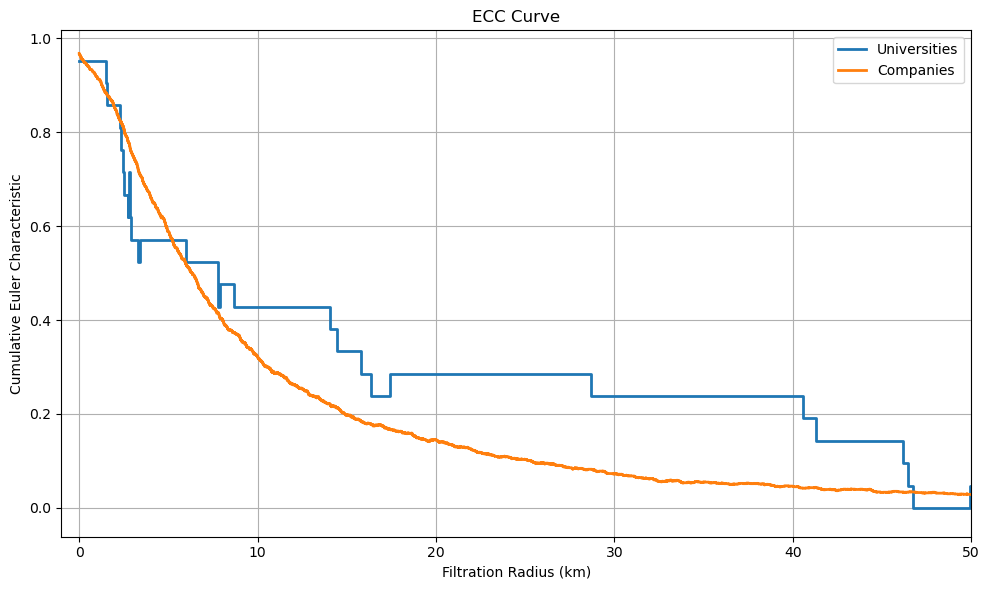

In [18]:
plt.figure(figsize=(10, 6))
plot_ecc(uni_coords, label="Universities", unit='km', xlim=(-1, 50))
plot_ecc(comp_coords, label="Companies", unit='km', xlim=(-1, 50))
plt.grid(True)
plt.tight_layout()
plt.show()